In [1]:
import pyvacon
import datetime as dt
import math

import pyvacon.marketdata.testdata as mkt_testdata
import pyvacon.tools.enums as enums
import pyvacon.marketdata.plot as mkt_plot
import pyvacon.models.plot as model_plot
import pyvacon.models.tools as model_tools

import pyvacon.analytics as analytics
import pyvacon.tools.converter as converter


from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.transforms as mtransforms
%matplotlib inline
import numpy as np

import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Generate Scenarios

In [2]:
# load test data from an Excel file
xl = pd.ExcelFile('TestDaten.xlsx')
#print(xl.sheet_names)

In [3]:
dfEONIA = xl.parse('EONIA')
dfEONIA = pd.DataFrame(dfEONIA,
                       columns = [
                           'stichtag6',
                           'prz_bs1j',
                           'prz_bs2j',
                           'prz_bs3j',
                           'prz_bs4j',
                           'prz_bs5j',
                           'prz_bs6j',
                           'prz_bs7j',
                           'prz_bs8j',
                           'prz_bs9j',
                           'prz_bs10j'
                       ])

# convert Excel dates to a human-readable format and add them to the data frame as a new column
dfEONIA['datum'] = pd.TimedeltaIndex(dfEONIA['stichtag6'], unit='d') + dt.datetime(1899, 12, 30)
#print(dfEONIA)

In [4]:
# absolute Differenzen berechnen
timeinterval = 1 # number of business days (TARGET2), i.e. the number of rows in the Excel sheet

# restrict to certain columns
dfDiffs = pd.DataFrame(dfEONIA,
                       columns = [
                           'prz_bs1j',
                           'prz_bs2j',
                           'prz_bs3j',
                           'prz_bs4j',
                           'prz_bs5j',
                           'prz_bs6j',
                           'prz_bs7j',
                           'prz_bs8j',
                           'prz_bs9j',
                           'prz_bs10j'
                       ])
#print(dfDiffs)

# save the current market data in a pandas.series
sCurrent = dfDiffs.iloc[0,:]
#print(sCurrent)

# Compute the elementwise difference (diff) of rows in the data frame (DF)
# diff[i] = DF[i]-DF[i-n]
# In words: For n = 1 we subtract from the values of any given row the values of the preceeding row
dfDiffs = dfDiffs.diff(periods=timeinterval)
#print(dfDiffs)

# Since we want
# diff[i] = DF[i-n]-DF[i], so that DF[i]+diff[i] = DF[i-n],
# we need to multiply by -1
dfDiffs = dfDiffs * (-1)
#print(dfDiffs)

# Get rid of the NaN rows
dfDiffs = dfDiffs.iloc[timeinterval:, :]
#print(dfDiffs)

# Compute the scenarios by adding the diffs to the current market data
dfScenarios = dfDiffs + sCurrent
#print(dfScenarios)
#print(sCurrent)
#print(dfDiffs.iloc[71,:])
#print(dfScenarios.iloc[71,:])

# Plot Scenarios

In [5]:
# Plot the current EONIA curve
samplingPoints = np.arange(10)+1 # expiry in years
sDistances = [ np.linalg.norm(row) for index, row in dfDiffs.iterrows() ]
dfScenWithDist = dfScenarios.copy()
#print(dfScenWithDist)
dfScenWithDist['dist'] = sDistances
#print(sDistances)
dfScenWithDist.sort_values(by = 'dist', ascending = False, inplace=True)
dfScenWithDist = dfScenWithDist.drop('dist', axis=1)
dfScenWithDist = dfScenWithDist.reset_index(drop=True)
#print(dfScenWithDist)
#print(dfScenWithDist.iloc[0:10])
exampleIndeces = dfScenWithDist.index.isin([0,4,5])

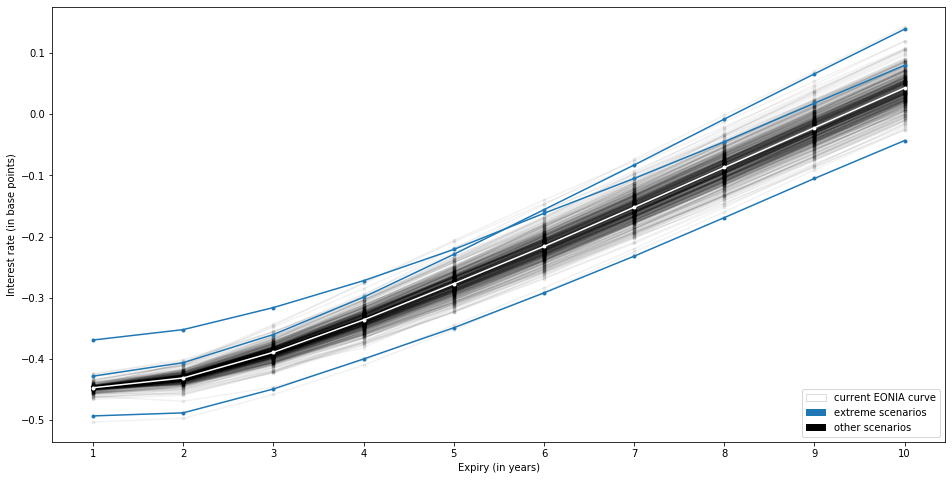

In [6]:
# Setup the graph
fig = plt.figure(figsize=(16,8))
ax = fig.gca()


colorCurrent = 'w'
colorBulk = 'k'
colorMinMaxDist = 'tab:blue'
ax.plot(samplingPoints, sCurrent, '.-', label = 'current EONIA curve', color = colorCurrent, zorder = 20)
ax.plot(samplingPoints, dfScenWithDist[~exampleIndeces].transpose(), '.-', label = 'other scenarios', color = colorBulk, zorder = 15, alpha=0.05)
ax.plot(samplingPoints, dfScenWithDist[exampleIndeces].transpose(), '.-', label = 'extreme scenarios', color = colorMinMaxDist, zorder = 15, alpha=1)
#ax.plot(samplingPoints, dfScenWithDist.iloc[0], '.-', label = 'EONIA rate', color = colorMinMaxDist, zorder = 20, alpha=1)
#ax.plot(samplingPoints, dfScenWithDist.iloc[4], '.-', label = 'EONIA rate', color = colorMinMaxDist, zorder = 20, alpha=1)
#ax.plot(samplingPoints, dfScenWithDist.iloc[5], '.-', label = 'EONIA rate', color = colorMinMaxDist, zorder = 20, alpha=1)


plt.xlabel('Expiry (in years)')
plt.ylabel('Interest rate (in base points)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))


legend_elements = [
    Patch(facecolor=colorCurrent, edgecolor='gainsboro', label='current EONIA curve'),
    Patch(facecolor=colorMinMaxDist, label='extreme scenarios'),
    Patch(facecolor=colorBulk, label='other scenarios')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

# Define a Portfolio
Start with one simple bond.

In [7]:
# define the reference date as the date of the first market data sample (rows are ordered by date desc)
refdate = dt.datetime(year = dfEONIA.iloc[0]['datum'].year, month = dfEONIA.iloc[0]['datum'].month, day = dfEONIA.iloc[0]['datum'].day)

duration = 10
maturity = dt.datetime(year = refdate.year + duration, month = refdate.month, day = refdate.day)
#print(refdate)
#print(maturity)

# Generate the coupon payment schedule as a vector of datetimes
coupon_dates = []
for i in range(duration):
    coupon_dates.append(dt.datetime(year = refdate.year + i + 1, month = refdate.month, day = refdate.day))
#print(coupon_dates)

# We now use these dates to define a fixed coupon bond
principal = 100.0
couponRate = 0.05
coupon_rates = [couponRate]*len(coupon_dates)
coupon_payments = [couponRate*principal]*len(coupon_dates)

fixed_coupon_bond = pyvacon.instruments.BondSpecification('Fixed_Coupon', 'DBK', enums.SecuritizationLevel.NONE, 'EUR',
    maturity, refdate, principal, enums.DayCounter.ACTACT, coupon_dates, coupon_rates, '', [], [])

# Compute the Credit Spread and Portfolio Values
First, we make some preparations.

In [8]:
# Define the pricer, we're going to use to price our bond
pricing_data_simple = pyvacon.pricing.BondPricingData()
pricing_data_simple.param = pyvacon.pricing.BondPricingParameter()
pricing_data_simple.param.useJLT = False
pricing_data_simple.pricingRequest = pyvacon.pricing.PricingRequest()
pricing_data_simple.pricingRequest.setCleanPrice(True)
pricing_data_simple.pricer = 'BondPricer'
pricing_data_simple.spec = fixed_coupon_bond

In [9]:
# We want to compute the value of our portfolio after the timeinterval (in days) defined above
valDate = refdate + dt.timedelta(days = timeinterval)
pricing_data_simple.valDate = valDate

# our market data contains the fixed swap rates for durations of 1 through 10 years
samplingPointsEONIA = []
for i in range(10):
    samplingPointsEONIA.append(dt.datetime(year = refdate.year + i + 1, month = refdate.month, day = refdate.day))
    
# convert to a format the DiscountCurve constructor understands
samplingPointsEONIA = converter.createPTimeList(refdate, samplingPointsEONIA)

### Compute Credit Spread

In [10]:
# Use the current EONIA rates + a constant rate to compute the price of the fixed coupon bond
# Vary the constant rate and repeat until the value of the bond is right about the same as its principal
creditSpread = couponRate * 100 # in base points
stepSize = couponRate * 100 # the initial step size used to vary the interest rate
spreads = []
values = []
for k in range(20):
    # create DC defined by the scenario
    dsc_fac = analytics.vectorDouble()
    spreadScenario = sCurrent + creditSpread;
    for i in range(len(spreadScenario)):
        dsc_fac.append(math.exp(-spreadScenario.iloc[i]/100*i)) # t = i years  # market data is given in base points -> /100  
            
    discountCurve = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, dsc_fac, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)
    pricing_data_simple.discountCurve = discountCurve
    
    results = pyvacon.pricing.price(pricing_data_simple)
    
    values.append(results.getPrice())
    spreads.append(creditSpread)
    
    if values[k] > principal:
        creditSpread += stepSize
    else:
        creditSpread -= stepSize
    stepSize /= 2

#print(spreads)
#print(values)
print(creditSpread)
    

5.568056106567383


### Compute Portfolio Values

In [11]:
# Compute the price of the fixed coupon bond at the valuation date defined above
# Repeat for every scenario
resultsDirty = []
resultsClean = []
for index, scenario in dfScenarios.iterrows():
    # add the credit spread we computed for our bond
    scenario = scenario + creditSpread
    
    # create DC defined by the scenario
    dsc_fac = analytics.vectorDouble()
    for i in range(len(scenario)):
            dsc_fac.append(math.exp(-scenario.iloc[i]/100*i)) # t = i years  # market data is given in base points -> /100  
            
    discountCurve = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, dsc_fac, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)
    pricing_data_simple.discountCurve = discountCurve
    
    results = pyvacon.pricing.price(pricing_data_simple)
    resultsDirty.append(results.getPrice())
    resultsClean.append(results.getCleanPrice())
    #print(pricing_data_simple.spec.getObjectId() + ', dirty price: ' + str(results.getPrice()) + ",  clean price: " + str(results.getCleanPrice()))
    

In [12]:
#print(scenario)
#print(scenario.to_numpy())
#print(resultsDirty)
#print(resultsClean)

minIndex = resultsDirty.index(min(resultsDirty))
#print(minIndex)
#print(resultsClean.index(min(resultsClean)))
print(resultsDirty[minIndex])
#print(resultsClean[minIndex])
#print(dfScenarios.iloc[minIndex])


maxIndex = resultsDirty.index(max(resultsDirty))
#print(maxIndex)
#print(resultsClean.index(max(resultsClean)))
print(resultsDirty[maxIndex])
#print(resultsClean[maxIndex])
#print(dfScenarios.iloc[maxIndex])

99.34172769371338
100.5932593521774


In [13]:
# compute the current value


# create DC defined by the scenario
dsc_fac = analytics.vectorDouble()
for i in range(len(scenario)):
        dsc_fac.append(math.exp(-(sCurrent + creditSpread).iloc[i]/100*i)) # t = i years  # market data is given in base points -> /100  

discountCurve = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, dsc_fac, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)
pricing_data_simple.discountCurve = discountCurve
results = pyvacon.pricing.price(pricing_data_simple)
currentPriceDirty = results.getPrice()
currentPriceClean = results.getCleanPrice()
print(currentPriceDirty)
#print(currentPriceClean)

99.99994569590885


# Plot pricing results

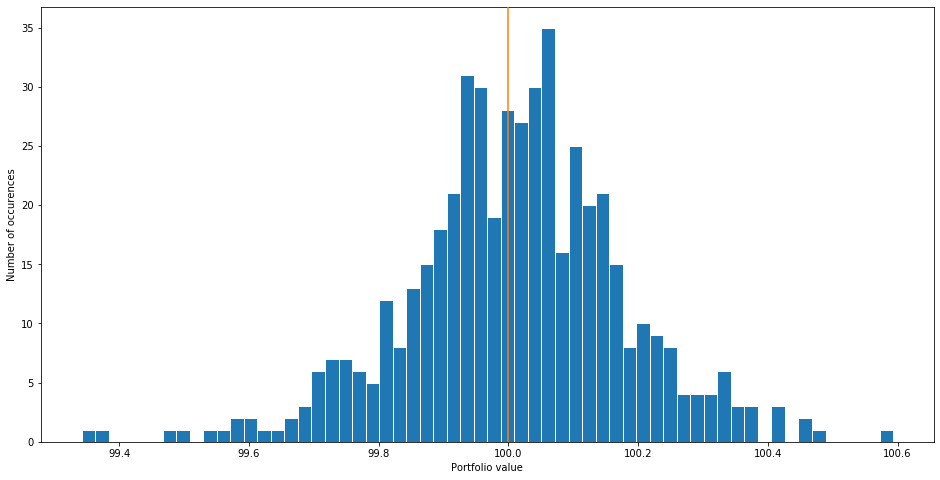

In [14]:
resultsDirty = np.sort(resultsDirty)
#resultsClean = np.sort(resultsClean)

# Histogramm
# Setup the graph
fig_values = plt.figure(figsize=(16,8))
ax = fig_values.gca()
#bx = ax.twinx()

colorHist = 'tab:blue'
colorCurrent = 'tab:orange'
ax.hist(resultsDirty, bins=60, color = colorHist, zorder = 20, edgecolor='w')
ax.axvline(x=currentPriceDirty, ymin=0, ymax=1, color=colorCurrent, zorder = 30)

plt.xlabel('Portfolio value')
plt.ylabel('Number of occurences')

plt.show()


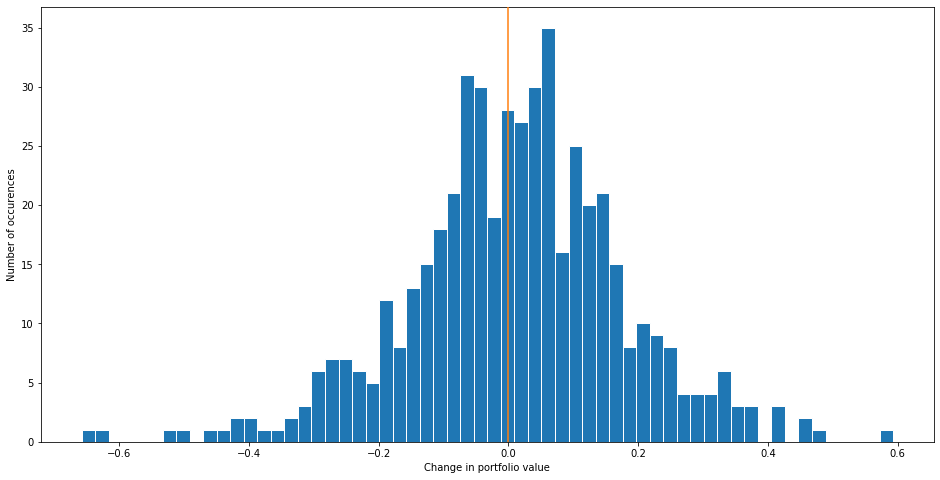

In [15]:
# Histogramm of the changes/differences in value
valDiffsDirty = np.asarray([res - currentPriceDirty for res in resultsDirty])
fig_diff = plt.figure(figsize=(16,8))
ax = fig_diff.gca()

colorHist = 'tab:blue'
colorCurrent = 'tab:orange'
#ax.plot(valDates, resultsDirtyFCB, '.', label = 'Dirty Price', color = colorPrice, zorder = 20)
ax.hist(valDiffsDirty, bins=60, color = colorHist, zorder = 20, edgecolor='w')
ax.axvline(x=0, ymin=0, ymax=1, color=colorCurrent, zorder = 30)

plt.xlabel('Change in portfolio value')
plt.ylabel('Number of occurences')

plt.show()

# Compute Value at Risk

In [16]:
valDiffsDirty = (-1)*np.sort((-1)*valDiffsDirty)
quantile = 0.99
#print(np.quantile(valDiffsDirty, 1-quantile, interpolation='higher')) # apparently always uses ascending order

# Compute the number of the entry corresponding to the quantile defined above
quantileIndex = np.ceil(len(valDiffsDirty)*quantile).astype(int)
#print(quantileIndex)
#print(quantile * len(valDiffsDirty))

# To get the index of this entry, we have to subtract 1
quantileIndex -= 1

print('With a probability of ' + ((quantileIndex + 1)/len(valDiffsDirty)*100).astype('str') + '%')
print('the value of our portfolio is not going to shrink by more than ' + (-1 * valDiffsDirty[quantileIndex]).astype('str'))
print('in the next ' + str(timeinterval) + ' day(s)')

# Check correctness
#print('--------------')
#print(valDiffsDirty[quantileIndex-1])
#print((quantileIndex)/len(valDiffsDirty))
#print('--------------')
#print(valDiffsDirty[quantileIndex])
#print((quantileIndex + 1)/len(valDiffsDirty))
#print('--------------')
#print(valDiffsDirty[quantileIndex+1])
#print((quantileIndex + 2)/len(valDiffsDirty))
#print('--------------')


With a probability of 99.19678714859438%
the value of our portfolio is not going to shrink by more than 0.45158214175046396
in the next 1 day(s)


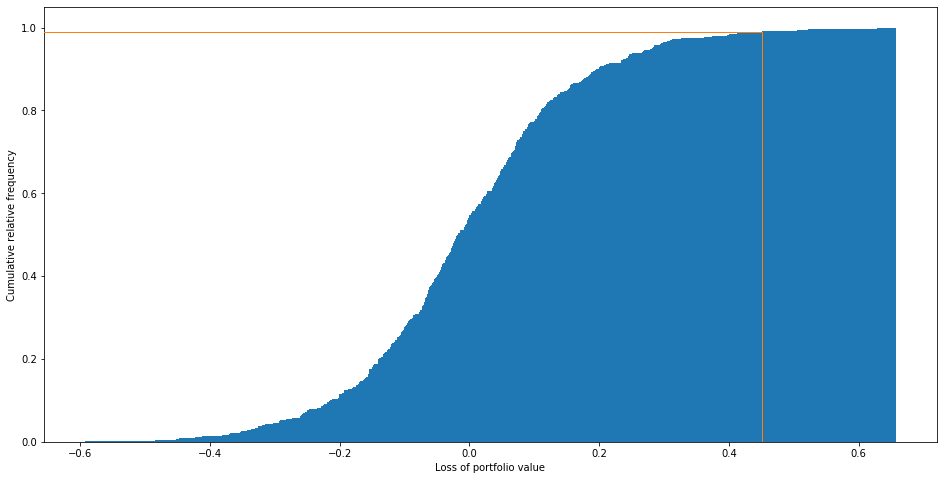

In [17]:
# Plot cummulative relative frequencies of loss of portfolio value
fig_diff = plt.figure(figsize=(16,8))
ax = fig_diff.gca()

losses = -valDiffsDirty
losses = np.sort(losses)

# choose bins in a way which maximizes the resolution of the histogramm
bins = np.unique(losses)
bins = np.append(bins, losses[len(losses)-1] + 0.00001 )

colorHist = 'tab:blue'
colorCurrent = 'tab:orange'
# 'density = True' produces relative frequencies instead of absolute numbers of occurences
ax.hist(losses, bins=bins, color = colorHist, cumulative = True, density = True, zorder = 20)

# draw lines to highlight the quantile
vlineAt = -valDiffsDirty[quantileIndex];
hline = ax.axhline(y=quantile, xmin=0, xmax=1, color=colorCurrent, linewidth=1, zorder = 30)
vline = ax.axvline(x=vlineAt, ymin=0, ymax=1, color=colorCurrent, linewidth=1, zorder = 30)

# clip the lines
eps = 0.1
xmin = ax.get_xlim()[0];
ymin = ax.get_ylim()[0];
hrect = Rectangle((xmin, quantile - eps), abs(xmin) + vlineAt, 2*eps, facecolor="none", edgecolor="none")
vrect = Rectangle((vlineAt - eps, ymin), 2*eps, abs(ymin) + quantile, facecolor="none", edgecolor="none")

ax.add_artist(hrect)
ax.add_artist(vrect)
hline.set_clip_path(hrect)
vline.set_clip_path(vrect)

# TODO: weiter dran arbeiten


plt.xlabel('Loss of portfolio value')
plt.ylabel('Cumulative relative frequency')

plt.show()

# Add a swap to our portfolio
We swap the fixed coupon payments for an interest rate of EONIA plus the credit spread we computed earlier.

In [18]:
# Define the swap scpecification
startdates = [refdate]
startdates.extend(coupon_dates[0:len(coupon_dates)-1])
#startdates = converter.createPTimeList(refdate, startdates)

enddates = coupon_dates
#enddates = converter.createPTimeList(enddates, startdates)

#print(startdates)
#print(enddates)

paydates = enddates
resetdates = startdates

notionals = analytics.vectorDouble()
notionals.append(principal)

fixedleg = analytics.IrFixedLegSpecification(couponRate, notionals, startdates, enddates, paydates,'EUR', enums.DayCounter.ACTACT)

floatleg = analytics.IrFloatLegSpecification(notionals, resetdates, startdates, enddates,
                                    paydates,'EUR', 'test_udl', enums.DayCounter.ACTACT, 
                                    0)
                                    #creditSpread/100) # spread is given in basepoints

ir_swap = analytics.InterestRateSwapSpecification('TEST_SWAP', 'DBK', enums.SecuritizationLevel.COLLATERALIZED, 'EUR',
                                           converter.getLTime(paydates[-1]), fixedleg, floatleg)


### Recompute the value of our portfolio in all scenarios

In [19]:
# Specify all data we need to price the swap
ir_swap_pricing_data = analytics.InterestRateSwapPricingData()

pay_leg_pricing_data = analytics.InterestRateSwapLegPricingData()
pay_leg_pricing_data.spec = ir_swap.getPayLeg()
pay_leg_pricing_data.fxRate = 1.0
pay_leg_pricing_data.weight = -1.0

rec_leg_pricing_data = analytics.InterestRateSwapFloatLegPricingData()
rec_leg_pricing_data.spec = ir_swap.getReceiveLeg()
rec_leg_pricing_data.fxRate = 1.0
rec_leg_pricing_data.weight = 1.0

ir_swap_pricing_data.pricer = 'InterestRateSwapPricer'
ir_swap_pricing_data.pricingRequest = analytics.PricingRequest()
ir_swap_pricing_data.valDate = converter.getLTime(refdate)
ir_swap_pricing_data.setCurr('EUR')
ir_swap_pricing_data.addLegData(pay_leg_pricing_data)
ir_swap_pricing_data.addLegData(rec_leg_pricing_data)

In [20]:
# Compute the price of our portfolio
# Repeat for every scenario
resultsDirty = []
resultsClean = []
for index, scenario in dfScenarios.iterrows():
    # add the credit spread we computed for our bond
    
    # create DC defined by the scenario
    factorsEONIA = analytics.vectorDouble()
    factorsWithSpread = analytics.vectorDouble()
    for i in range(len(scenario)):
        factorsEONIA.append(math.exp(-scenario.iloc[i]/100*i)) # t = i years  # market data is given in base points -> /100  
        factorsWithSpread.append(math.exp(-(scenario.iloc[i] + creditSpread)/100*i)) # t = i years  # market data is given in base points -> /100  
            
    dcEONIA = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, factorsEONIA, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)
    dcWithSpread   = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, factorsWithSpread, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)
    
    pricing_data_simple.discountCurve = dcEONIA # dcWithSpread
    pay_leg_pricing_data.discountCurve = dcEONIA
    rec_leg_pricing_data.discountCurve = dcEONIA
    rec_leg_pricing_data.fixingCurve = dcEONIA
    
    prBond = pyvacon.pricing.price(pricing_data_simple)
    prSwap = analytics.price(ir_swap_pricing_data)
    dirty = prBond.getPrice() + prSwap.getPrice()
    clean = prBond.getCleanPrice() + prSwap.getCleanPrice()
    resultsDirty.append(dirty)
    resultsClean.append(clean)
    #print(pricing_data_simple.spec.getObjectId() + ', dirty price: ' + str(results.getPrice()) + ",  clean price: " + str(results.getCleanPrice()))
#print(resultsDirty)

In [21]:
#analytics.setLogLevel('DEBUG')
#tic = dt.datetime.now()
#pr = analytics.price(ir_swap_pricing_data)
#print('runtime: {}'.format(dt.datetime.now() - tic))
#pr.getPrice()

### Compute the current value as a reference

In [22]:
# Define a discount curve based on the current EONIA rates
factorsEONIA = analytics.vectorDouble()
factorsWithSpread = analytics.vectorDouble()
for i in range(len(sCurrent)):
    factorsEONIA.append(math.exp(-sCurrent.iloc[i]/100*i)) # t = i years  # market data is given in base points -> /100  
    factorsWithSpread.append(math.exp(-(sCurrent.iloc[i] + creditSpread)/100*i)) # t = i years  # market data is given in base points -> /100  
    
dcEONIA = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, factorsEONIA, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)
dcWithSpread = analytics.DiscountCurve('dc_linear', refdate, samplingPointsEONIA, factorsWithSpread, enums.DayCounter.ACTACT, enums.InterpolationType.LINEAR, enums.ExtrapolationType.NONE)

pricing_data_simple.discountCurve = dcEONIA # dcWithSpread
pay_leg_pricing_data.discountCurve = dcEONIA
rec_leg_pricing_data.discountCurve = dcEONIA 
rec_leg_pricing_data.fixingCurve = dcEONIA

# compute portfolio value
prBond = pyvacon.pricing.price(pricing_data_simple)
prSwap = analytics.price(ir_swap_pricing_data)
print(prSwap.getPrice())
print(prBond.getPrice())
currentValue = prBond.getPrice() + prSwap.getPrice()
print(currentValue)

-49.90089841782419
149.90089841782418
100.0


### Plot the pricing results

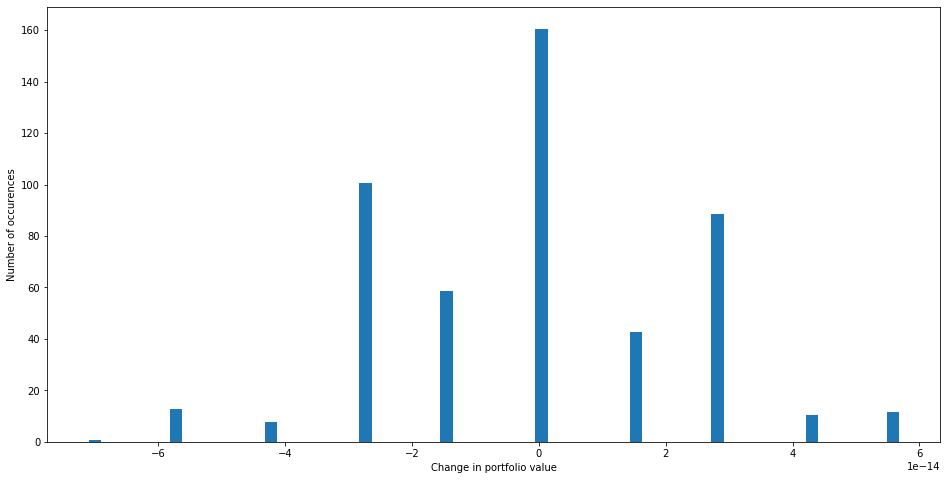

In [23]:
# Histogramm of the changes/differences in value
valDiffsDirty = np.asarray([res - currentValue for res in resultsDirty])
fig_diff = plt.figure(figsize=(16,8))
ax = fig_diff.gca()

colorHist = 'tab:blue'
colorCurrent = 'tab:orange'
#ax.plot(valDates, resultsDirtyFCB, '.', label = 'Dirty Price', color = colorPrice, zorder = 20)
ax.hist(valDiffsDirty, bins=60, color = colorHist, zorder = 20, edgecolor='w')
#ax.axvline(x=0, ymin=0, ymax=1, color=colorCurrent, zorder = 30)

plt.xlabel('Change in portfolio value')
plt.ylabel('Number of occurences')

plt.show()

# TODO
- Das Wort 'current' als Beschreibung für die jüngste in den Marktdaten vorhandene EONIA-Kurve stört mich
- Farben usw, die mehrfach verwendet werden,nur an einer Stelle zuweisen und anschließend nur noch lesend verwenden?
